# Notebook to analyse SIMBAD and GAIA counterparts
Set your option in the cell bellow

In [1]:
region_name = "ALL_10-800" #"CAINGSGII_10-800" #"TDS" #"CAINGSGII_10-800" #"WD" #"MDIS_10-800" #"TDS" #  _ELAISN1
region_dir_name = "./vasca_pipeline/"+region_name+"/"
region_cat_fname = region_dir_name+"region_"+region_name+"_cat.fits"

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from vasca.region import Region
import vasca.visualization as vvis
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, get_col_cycler,add_ogrp, color_palette, nb_fig, flux2mag_np, mag2flux_np
from astropy import units as uu

from loguru import logger
logger.enable("vasca")

# Get region
rc = Region()
rc.load_from_fits(region_cat_fname)
#rc.tt_gaiadr3.rename_column("E_BP-RP_","E_BP-RP")

# Get SIMBAD object type info
tt_nodes = Table.read("./resources/SIMBAD_otypes/otypes_nodes.csv")
tt_nodes.rename_column("Id", "otype")
add_ogrp(tt_nodes)

#Reset source selection
rc.tt_sources["sel"]=True


2024-02-12 11:20:48.287 | DEBUG    | vasca.tables:load_from_fits:328 - Loading file with name './vasca_pipeline/ALL_10-800/region_ALL_10-800_cat.fits'
2024-02-12 11:20:48.297 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_fields'
2024-02-12 11:20:48.311 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_filters'
2024-02-12 11:20:48.318 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_visits'
2024-02-12 11:20:48.325 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_sources'
2024-02-12 11:20:48.348 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_detections'
2024-02-12 11:20:48.373 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_coadd_detections'
2024-02-12 11:20:48.439 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_coadd_sources'
2024-02-12 11:20:48.457 | DEBUG    | vasca.tables:load_from_fits:339 - Loading table 'tt_src_id_map'
2024-02-12 11:20:48.465 | DEBUG    | vasca.tab

In [3]:
display(rc.tt_gaiadr3) # ["E_BP-RP_"]

_q,ra,dec,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RUWE,FG,e_FG,Gmag,FBP,e_FBP,BPmag,FRP,e_FRP,RPmag,BP-RP,RV,e_RV,Vbroad,GRVSmag,QSO,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,__Fe_H_,Dist,A0,HIP,PS1,SDSS13,SKYM2,TYC2,URAT1,AllWISE,APASS9,GSC23,RAVE5,_2MASS,RAVE6,RAJ2000,DEJ2000,PQSO,PGal,PSS,RPlx,VarFlag,o_Gmag,RFRP,RFBP,AG,E_BP-RP,rg_src_id,match_distance,gaiadr3_match_id,Gmag_abs,Plx_dist,ogrp
,deg,deg,,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,,,mag,,,mag,mag,km / s,km / s,km / s,mag,,,,,,,,,,,,K,log(cm.s**-2),,pc,mag,,,,,,,,,,,,,deg,deg,,,,,,,,,mag,mag,,arcsec,,,pc,
int32,float64,float64,int64,float64,float64,float64,float32,float64,float64,float32,float64,float32,float64,float64,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float32,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,int32,int64,int64,int32,bytes12,bytes15,bytes19,int32,bytes10,bytes16,bytes17,bytes21,float64,float64,float64,float64,float64,float64,bytes13,int16,float32,float32,float32,float32,int32,float64,int32,float32,float64,bytes8
1,150.2,2.1,3836069006998531584,2.2872,3.3137,--,--,--,--,--,--,--,--,95.82888,1.689,20.733625,93.75,16.38,20.408556,130.9,9.985,19.455320,0.953236,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,110481501947501974,1237651753997304055,--,--,--,J100046.74+020404.4,--,N6SS000981,--,--,--,150.2,2.1,0.001869,0.000724,0.996765,--,NOT_AVAILABLE,79,13.11,5.725,--,--,41,0.6956587221689177,0,-100.0,--,none
2,150.1,2.0,3836046123412862208,1.5776,2.0453,--,--,--,--,--,--,--,--,90.12499,2.676,20.800253,37.12,20.52,21.414429,59.56,10.83,20.310590,1.103838,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,110451501456232172,1237651736280760581,--,--,--,J100034.94+020234.9,--,N6SS004829,--,--,--,150.1,2.0,0.001265,0.000013,0.997987,--,NOT_AVAILABLE,43,5.497,1.809,--,--,68,0.6420858569707824,1,-100.0,--,none
4,150.1,2.1,3836257710681556224,0.5228,0.5439,-0.0737,0.5331,0.702,-0.580,0.607,0.396,0.641,1.065,231.69009,2.456,19.775099,160.4,10.57,19.825287,132.1,14.81,19.445590,0.379698,--,--,--,--,1,0,0,0,0,0,1,0,0,0,0,--,--,--,--,--,--,110521501020297033,1237651753997238486,--,--,--,J100024.44+020619.5,--,N6SV003245,--,--,--,150.1,2.1,1.000000,0.000000,0.000000,-0.1383,VARIABLE,182,8.917,15.18,--,--,87,1.015315761207988,2,-100.0,--,AGN
7,215.1,52.6,1607957522794289024,0.1805,0.2101,-0.4327,0.2279,0.356,0.190,0.223,0.302,0.256,1.036,311.79894,1.36,19.452680,178.4,9.809,19.709816,189.3,7.18,19.055190,0.654627,--,--,--,--,1,0,0,0,0,0,1,0,0,0,0,--,--,--,--,--,--,171142150651746989,1237661385994862739,--,--,--,J142015.62+523718.5,--,N5MV001218,--,--,--,215.1,52.6,1.000000,0.000000,0.000000,-1.8990,VARIABLE,482,26.36,18.19,--,--,302,0.26795579682948123,3,-100.0,--,AGN
8,215.0,52.7,1607958480571152256,0.8988,0.7715,-1.1739,0.6843,0.532,-0.092,1.013,0.524,0.894,1.079,127.05163,2.726,20.427416,98.51,10.98,20.354832,127.2,7.357,19.486479,0.868353,--,--,--,--,1,0,0,0,0,0,1,0,0,0,0,--,--,--,--,--,--,171212150426430532,1237661385994862858,--,--,--,J142010.22+524029.6,--,N5MV001750,--,--,--,215.0,52.7,0.999765,0.000220,0.000015,-1.7155,VARIABLE,283,17.29,8.972,--,--,314,0.5654019830257911,4,-100.0,--,AGN
9,214.9,52.5,1607951746062355328,0.2074,0.2337,0.1023,0.2656,0.429,-0.239,0.256,-0.357,0.272,0.966,233.47251,0.8803,19.766777,140.9,7.083,19.965982,148.7,6.695,19.317305,0.648678,--,--,--,--,1,0,0,0,0,0,1,0,0,0,0,--,--,--,--,--,--,171052149430476033,1237661385994862854,--,--,--,J141946.35+523246.3,--,N5MV000642,--,--,--,214.9,52.5,1.000000,0.000000,0.000000,0.3850,VARIABLE,523,22.21,19.9,--,--,336,0.5780435001189599,5,-100.0,9775.1711,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

### Prepare association data for plotting

In [4]:
#Add Object group to source table
rc.copy_table_columns("tt_sources","tt_simbad",["otype","ogrp","match_distance"],"simbad_match_id")
rc.tt_sources.rename_column("match_distance","match_distance_simbad")
rc.tt_sources.rename_column("ogrp","ogrp_simbad")
sel_simbad = rc.tt_sources["simbad_match_id"]>0.5
print(f"Number of SIMBAD matches is: {sel_simbad.sum()}  ({100* sel_simbad.sum() / len(rc.tt_sources)} )%")

rc.copy_table_columns("tt_sources","tt_gaiadr3",["PQSO", "PGal", "PSS","match_distance","Gmag_abs","BP-RP", "ogrp", "Plx_dist", "E_BP-RP","AG","RFRP", "RFBP", "RPlx"],"gaiadr3_match_id")
rc.tt_sources.rename_column("match_distance","match_distance_gaiadr3")
rc.tt_sources.rename_column("ogrp","ogrp_gaiadr3")
sel_gaiadr3 = rc.tt_sources["gaiadr3_match_id"]>0.5
print(f"Number of GAIA matches is: {sel_gaiadr3.sum()}  ({100*sel_gaiadr3.sum() / len(rc.tt_sources)} )%")

sel_match = np.array(sel_simbad+sel_gaiadr3, dtype=bool)
print(f"Total number of matches is: {sel_match.sum()}  ({100*sel_match.sum() / len(rc.tt_sources)} )%")
print(f"Total number of sources is: {len(rc.tt_sources)}")

#Copy lomb scargle result into tt_sources
rc.copy_table_columns("tt_sources","tt_lombscargle",["ls_peak_pval", "ls_model_rchiq"],"rg_src_id")


2024-02-12 11:20:48.683 | DEBUG    | vasca.tables:copy_table_columns:1122 - Copying columns ['otype', 'ogrp', 'match_distance'] from table tt_simbad to tt_sources matching simbad_match_id 
2024-02-12 11:20:49.064 | DEBUG    | vasca.tables:copy_table_columns:1122 - Copying columns ['PQSO', 'PGal', 'PSS', 'match_distance', 'Gmag_abs', 'BP-RP', 'ogrp', 'Plx_dist', 'E_BP-RP', 'AG', 'RFRP', 'RFBP', 'RPlx'] from table tt_gaiadr3 to tt_sources matching gaiadr3_match_id 


Number of SIMBAD matches is: 2686  (63.921941932413134 )%


2024-02-12 11:20:49.524 | DEBUG    | vasca.tables:copy_table_columns:1122 - Copying columns ['ls_peak_pval', 'ls_model_rchiq'] from table tt_lombscargle to tt_sources matching rg_src_id 


Number of GAIA matches is: 3301  (78.55782960495003 )%
Total number of matches is: 3655  (86.98238933841029 )%
Total number of sources is: 4202


In [5]:
display(rc.tt_sources[rc.tt_sources["rg_src_id"]==65591])
display(rc.tt_simbad[rc.tt_simbad["rg_src_id"]==65591])
display(rc.tt_gaiadr3[rc.tt_gaiadr3["rg_src_id"]==65591])

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,gaiaedr3_wd_match_id,simbad_match_id,gaiadr3_match_id,gfcat_src_id,gfcat_dist,flux_ne,src_name,otype,ogrp_simbad,match_distance_simbad,PQSO,PGal,PSS,match_distance_gaiadr3,Gmag_abs,BP-RP,ogrp_gaiadr3,Plx_dist,E_BP-RP,AG,RFRP,RFBP,RPlx,ls_peak_pval,ls_model_rchiq
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,arcsec,,,,,arcsec,,,,arcsec,,,,pc,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,int32,int32,int32,int64,float32,float32[2],bytes24,bytes32,bytes8,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32
-1,27 .. -1,53.283919336066226,-27.247928445672596,0.14070727,-0.15868823,0.3968736,0.7216638,0.68481874,982343,0.09767474,1 .. 0,True,5.857592 .. -1.0,0.11351098 .. -1.0,0.09525697 .. -100.0,3.62638 .. -1.0,5.9373e-41 .. -1.0,10.096816 .. -1.0,1.2852343 .. 1.0,7.9974575 .. 0.0,-1,65591,3,-1.0,-1.0,-1,603,-1,-1,-1.0,0.3086373 .. --,1UVA J33308.1-271452.5,SN*,Misc,0.7936793,-1.0,-1.0,-1.0,-1.0,-100.0,-1.0,none,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.6418046e-07,1.9753165


main_id,ra,dec,ra_prec,dec_prec,coo_err_maja,coo_err_mina,coo_err_angle,coo_qual,coo_wavelength,coo_bibcode,otype,otypes,distance_distance,distance_q,distance_unit,distance_merr,distance_perr,distance_method,distance_bibcode,match_distance,rvz_type,rvz_radvel,rvz_error,rvz_qual,rvz_wavelength,rvz_bibcode,z_value,sp_type,sp_qual,sp_bibcode,script_number_id,rg_src_id,simbad_match_id,ogrp
,deg,deg,,,mas,mas,deg,,,,,,,,,,,,,arcsec,,km / s,km / s,,,,,,,,,,,
bytes32,float64,float64,int16,int16,float32,float32,int16,bytes1,bytes1,bytes32,bytes32,bytes32,float64,bytes1,bytes4,float64,float64,bytes8,bytes19,float32,bytes1,float64,float32,bytes1,bytes1,bytes32,float64,bytes32,bytes32,bytes32,int32,int32,int32,bytes8
[CBP2015] cdfs1 r 20121007 43A,53.28416666666666,-27.247944444444446,6,6,--,--,0,C,O,2015A&A...584A..62C,SN*,SN*,--,--,--,--,--,--,--,0.7937,z,0.640,--,E,O,2015A&A...584A..62C,0.6400000,--,--,--,837,65591,603,Misc


_q,ra,dec,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RUWE,FG,e_FG,Gmag,FBP,e_FBP,BPmag,FRP,e_FRP,RPmag,BP-RP,RV,e_RV,Vbroad,GRVSmag,QSO,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,__Fe_H_,Dist,A0,HIP,PS1,SDSS13,SKYM2,TYC2,URAT1,AllWISE,APASS9,GSC23,RAVE5,_2MASS,RAVE6,RAJ2000,DEJ2000,PQSO,PGal,PSS,RPlx,VarFlag,o_Gmag,RFRP,RFBP,AG,E_BP-RP,rg_src_id,match_distance,gaiadr3_match_id,Gmag_abs,Plx_dist,ogrp
,deg,deg,,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,,,mag,,,mag,mag,km / s,km / s,km / s,mag,,,,,,,,,,,,K,log(cm.s**-2),,pc,mag,,,,,,,,,,,,,deg,deg,,,,,,,,,mag,mag,,arcsec,,,pc,
int32,float64,float64,int64,float64,float64,float64,float32,float64,float64,float32,float64,float32,float64,float64,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float32,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,int32,int64,int64,int32,bytes12,bytes15,bytes19,int32,bytes10,bytes16,bytes17,bytes21,float64,float64,float64,float64,float64,float64,bytes13,int16,float32,float32,float32,float32,int32,float64,int32,float32,float64,bytes8


### Plot matched SIMBAD object types

Skipping otype none


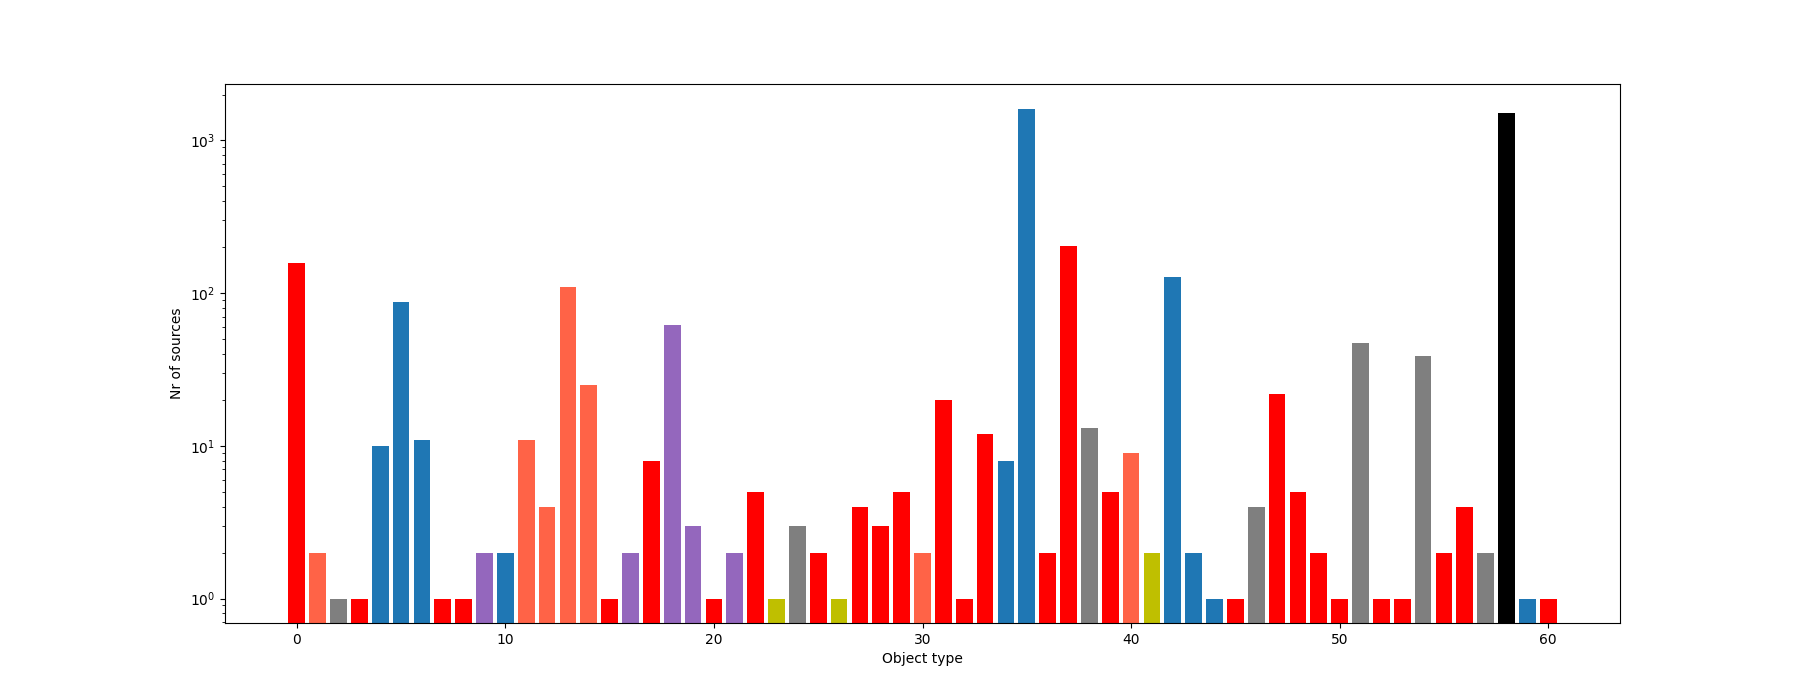

In [6]:
#Prepare data
otypes_all, otype_cts_all= np.unique(rc.tt_sources["otype"],return_counts=True)
dd_otype2id = dict(zip(list(otypes_all),range(len(otypes_all))))

#Prepare table to plot pycharts
onames = ["otype", "ogrp","Description","Label", "sure", "nr_srcs"]
odtypes = ["S8"  ,"S8"   , "S128"        ,"S8"  , bool, np.int32  ]
tt_otypes = Table(names=onames, dtype=odtypes)

#Do bar chart of all otypes color coded by ogrp
fig_otypes = plt.figure("Source types",figsize=(18, 7), clear=True)
fig_otypes.clf()
tt_mt_grp =  rc.tt_sources.group_by("ogrp_simbad")
sel_nodes = np.zeros(len(tt_nodes), dtype=bool)
for group, tt_grp in zip(tt_mt_grp.groups.keys, tt_mt_grp.groups):
    otypes, otype_cts= np.unique(tt_grp["otype"],return_counts=True)
    otypes_id = []
    for ii in range(len(otypes)):
        otype = otypes[ii]
        otype_ct = otype_cts[ii]
        otypes_id.append(dd_otype2id[otype])
        sure = True 
        sel_node = tt_nodes["otype"]==otype
        if sel_node.sum()!=1:
            sel_node = tt_nodes["Candidate"]==otype
            sure = False
        if sel_node.sum()!=1:
            print("Skipping otype",otype)
            continue
        tt_row = tt_nodes[sel_node]
        ll_row = [otype,tt_row["ogrp"].data[0].decode('UTF-8'),tt_row["Description"].data[0],tt_row["Label"].data[0],sure,otype_ct]
        tt_otypes.add_row(ll_row)
        sel_nodes += sel_node
    plt.bar( otypes_id, otype_cts, align='center', label=group[0], color = dd_ogrp2col[group[0]])
plt.yscale('log')
#plt.grid()
plt.xlabel("Object type")
plt.ylabel("Nr of sources")
plt.show()
plt.legend()
_ = plt.xticks(range(len(otypes_all)), otypes_all, size='small')

#Printout otypes whch have no ogrp assigned yet
sel_ogrp_none = rc.tt_simbad["ogrp"]=="none"
if sel_ogrp_none.sum()>0:
    print("Unclassified new otypes:")
    display(rc.tt_simbad["main_id","otype","rg_src_id"][sel_ogrp_none])

#tt_nodes["otype","Candidate","Description","ogrp","Label","Category","Subcategory"][sel_nodes].pprint_all()
#tt_otypes.pprint_all()

### Draw pychart and print secured matches

 ogrp  otype             Description              nr_srcs
------ ----- ------------------------------------ -------
   AGN   AGN                Active Galaxy Nucleus      87
   AGN   BLL                               BL Lac      11
   AGN   Bla                               Blazar       2
   AGN   QSO                               Quasar    1620
   AGN   Sy1                     Seyfert 1 Galaxy     127
   AGN   Sy2                     Seyfert 2 Galaxy       2
   AGN   SyG                       Seyfert Galaxy       1
   AGN    rG                         Radio Galaxy       1
Binary    **              Double or Multiple Star       2
Binary   CV*                   Cataclysmic Binary      11
Binary   EB*                     Eclipsing Binary     109
Binary   No*                       Classical Nova       2
Binary   SB*                 Spectroscopic Binary       9
Galaxy   BiC  Brightest Galaxy in a Cluster (BCG)       2
Galaxy   EmG                 Emission-line galaxy       2
Galaxy     G  

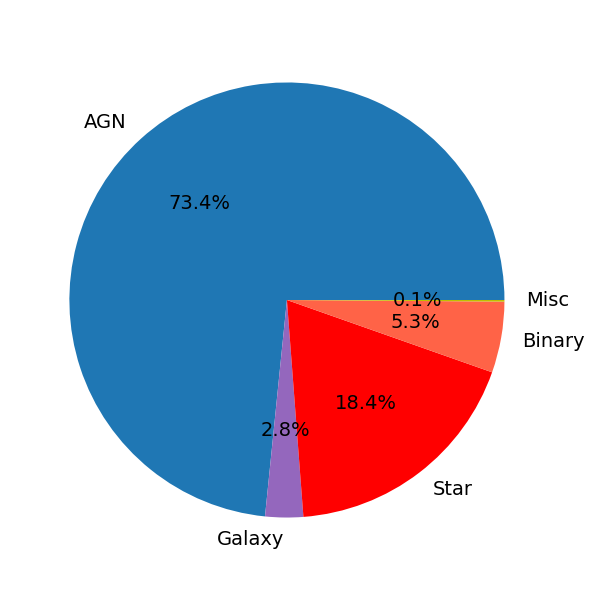

In [7]:
# Pie chart showing fractions of grouped classification
tt_otypes["sure"][tt_otypes["ogrp"]=="Unkown"]=False
tt_osure = tt_otypes[tt_otypes["sure"]==True]["ogrp","otype","Description","nr_srcs"]
tt_osure.pprint_all()
tt_osure.write(region_dir_name+"SIMBAD_otypes.tex", format='latex',overwrite=True)

# Grouped classifications
ogroups = ["AGN","Galaxy","Star","Binary","Misc"]  #,"Unkown"
ogrp_col = [ dd_ogrp2col[ogroups[ii]] for ii in range(len(ogroups))]
ogrps_nr = []
for ogrp in ogroups:
    ogrps_nr.append(tt_osure[tt_osure["ogrp"]==ogrp]["nr_srcs"].sum())

# Chart
fig, ax = plt.subplots(1,1,figsize=(6, 6), num="pie", clear=True)
fig.set_tight_layout(True)
plt.subplots_adjust(left=0.0, bottom=0, right=1., top=1., wspace=None, hspace=None)
_ = ax.pie(ogrps_nr, labels=ogroups,colors=ogrp_col, autopct='%1.1f%%', textprops={'fontsize': 14})
fig.savefig(region_dir_name +"pie_simbad_ogroups.pdf")

### Scatter plots of source variables by group

2024-02-12 11:20:50.095 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'flux'
2024-02-12 11:20:50.107 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'hr'
2024-02-12 11:20:50.118 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'flux'
2024-02-12 11:20:50.128 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'hr'
2024-02-12 11:20:50.137 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'flux'
2024-02-12 11:20:50.147 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'hr'
2024-02-12 11:20:50.158 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'flux'
2024-02-12 11:20:50.168 | DEBUG    | vasca.visualization:plot_table_scatter:545 - Plotting of variables 'flux_nxv' and 'hr'


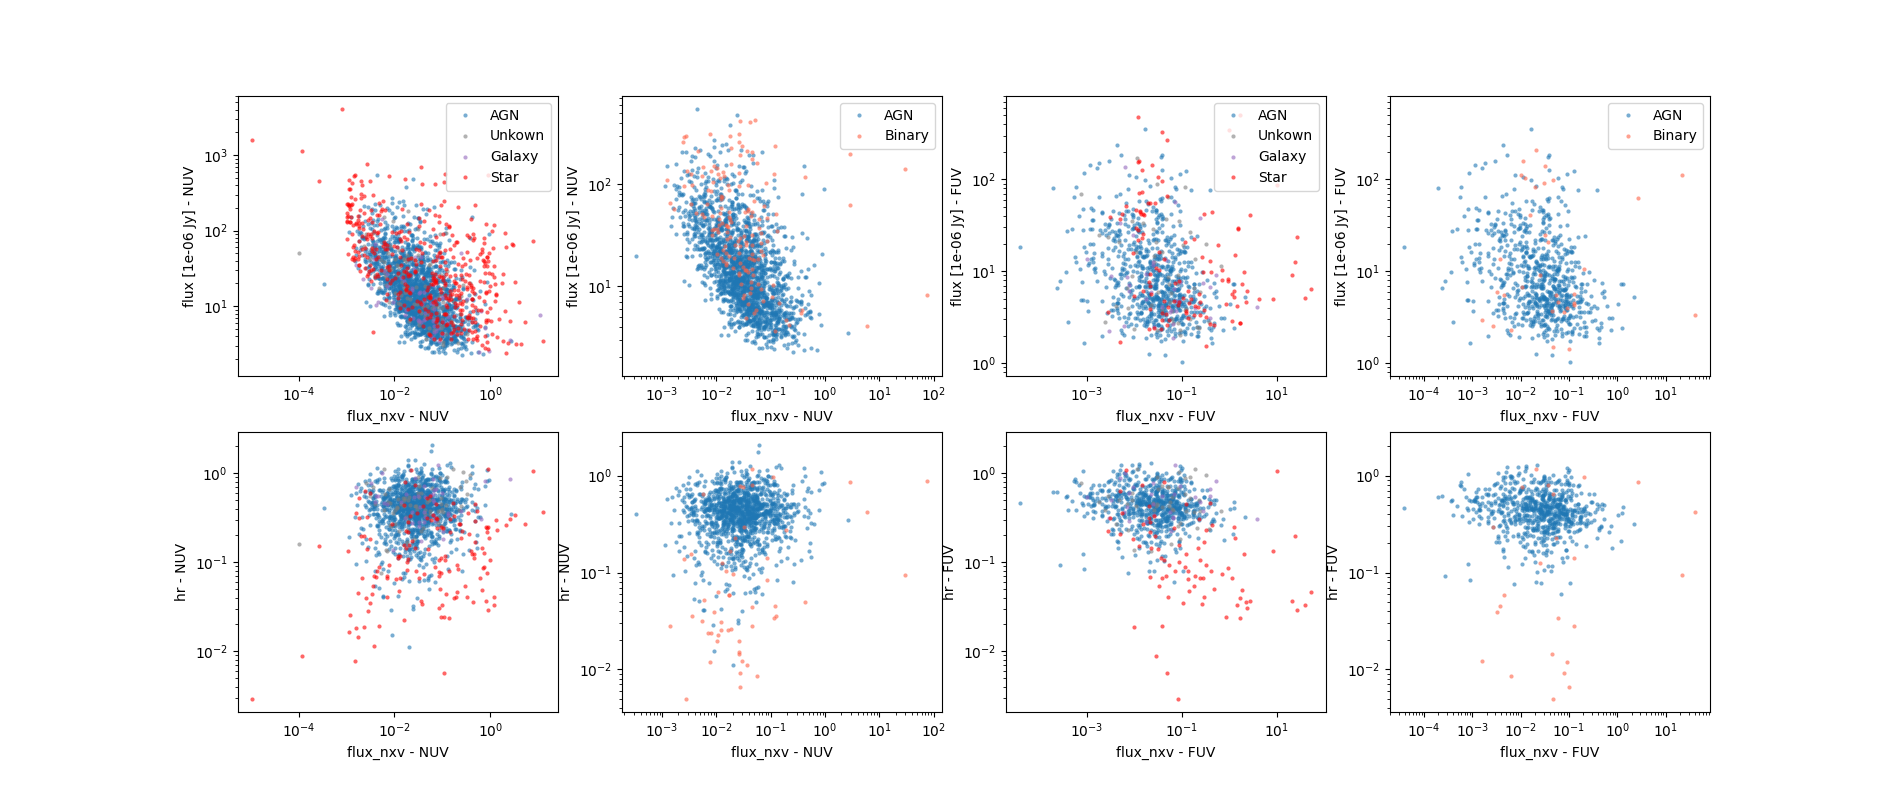

In [8]:
plot_kwargs = {"markersize": 3.0,"alpha":0.6}
fig, axs = plt.subplots(2, 4, figsize=(19, 8))
#fig.clf()
axs = axs.flatten()
plt_ogrops = [["AGN","Unkown","Galaxy",'Star'],["AGN", 'Binary']]

plt_flts = [1,2]
ctr = 0
for flt in plt_flts:
    for ogrps in plt_ogrops:
        axs[ctr].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "flux", ax=axs[ctr], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp_simbad",grp_vals = ogrps,**plot_kwargs)

        axs[ctr+4].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "hr", ax=axs[ctr+4], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp_simbad",grp_vals = ogrps,**plot_kwargs)
        ctr +=1

_ = axs[0].legend()
_ = axs[1].legend()
_ = axs[2].legend()
_ = axs[3].legend()
#print(dd_ogrp2otypes.keys())r

### Compare object classification from SIMBAD to the one from GAIA-DR3

2024-02-12 11:20:50.867 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PQSO'
/home/buehler/miniforge3/envs/vas/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
2024-02-12 11:20:50.889 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PQSO'
2024-02-12 11:20:50.892 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PQSO'
2024-02-12 11:20:50.895 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PSS'
2024-02-12 11:20:50.915 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PSS'
2024-02-12 11:20:50.917 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PSS'
2024-02-12 11:20:50.920 | DEBUG    | vasca.visualization:plot_table_hist:447 - Plotting histogram of variable 'PGal'
2024-02

SIMBAD assoc: orange:AGN; red:Star; brown:Galaxy


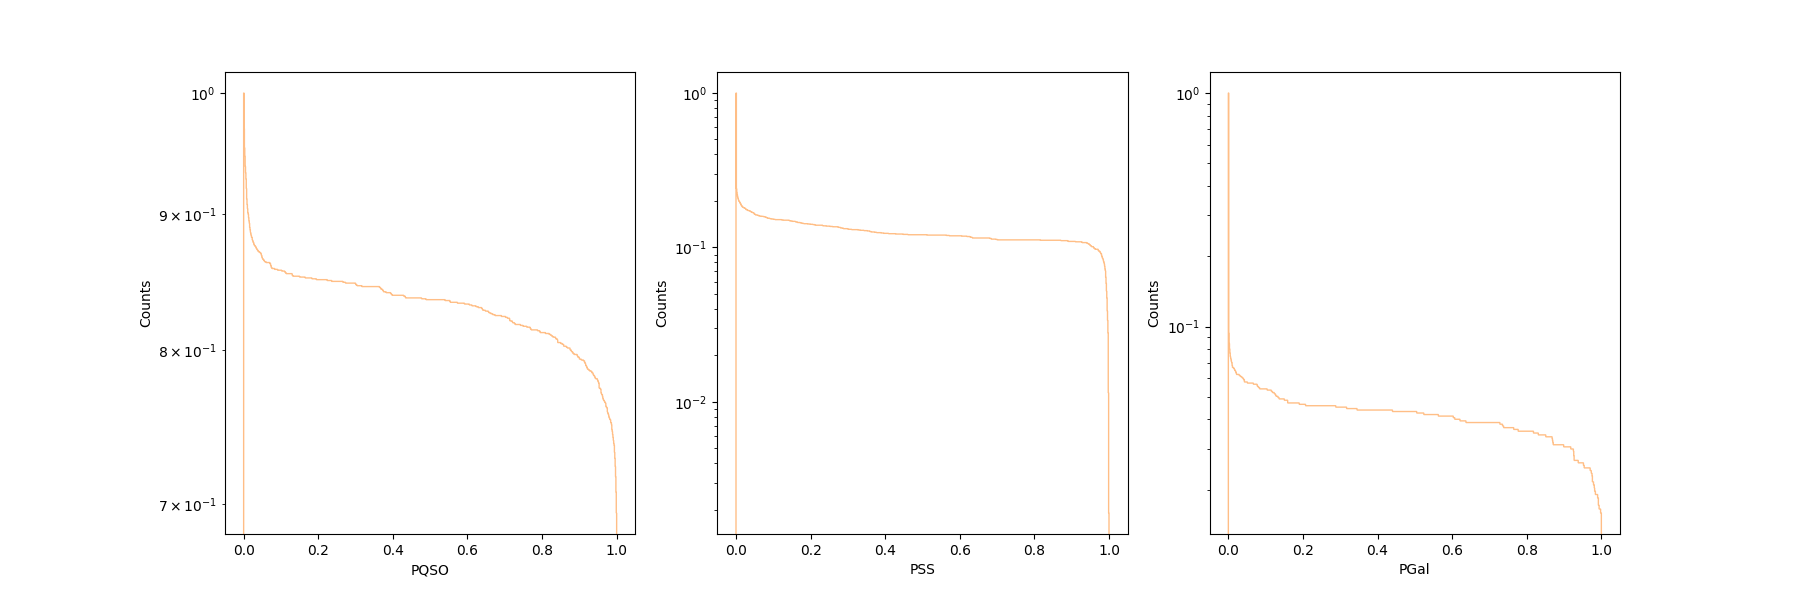

In [9]:
#Define selections for different SIMBAD object groups
sel_AGN = rc.tt_sources["ogrp_simbad"]=="AGN"
sel_star = np.array((rc.tt_sources["ogrp_simbad"]=="Star*")+(rc.tt_sources["ogrp_simbad"]=="S*"), dtype=bool)
sel_gal = rc.tt_sources["ogrp_simbad"]=="GAL"
sels_ogrp = [sel_AGN,sel_star,sel_gal]

#GAIA variables to plot
gaia_vars = ["PQSO","PSS","PGal"]

#Define figure parameters and loop to do plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6),num="Cummulative probabilities of object groups")
hist_bins = np.linspace(0.0,1.0,1001)
hist_dens = True
axs = np.array(axs).flatten()
panel = 0
cumulative = -1
for var in gaia_vars:
    for sel in sels_ogrp:
        _ = vvis.plot_table_hist(rc.tt_sources[sel], var, ax=axs[panel], density= hist_dens, bins=hist_bins,cumulative= cumulative )
    panel+=1
    
#Print out figure labels
print("SIMBAD assoc: orange:AGN; red:Star; brown:Galaxy")

### Hertzsprung russel diagram

In [10]:
#Adapted from https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries
from astroquery.gaia import Gaia
from astropy import units as uu
import os

gaia_file = region_dir_name+"GAIA_stars.fits"

if os.path.isfile(gaia_file):
    tt_res = Table.read(gaia_file)
else:
    tables = Gaia.load_tables(only_names=True)
    #for table in tables:
    #    print(table.name)
    
    meta = Gaia.load_table('gaiadr3.gaia_source')
    #for column in meta.columns:
    #    print(column.name)
    query = """SELECT 
bp_rp, phot_g_mean_mag+5*log10(parallax)-10 as gmag_abs, ag_gspphot, ebpminrp_gspphot,parallax, parallax_over_error, phot_bp_mean_flux_over_error,
phot_rp_mean_flux_over_error, visibility_periods_used, astrometric_excess_noise, phot_g_mean_flux_over_error
FROM gaiadr3.gaia_source
WHERE (parallax > 5 OR ag_gspphot > 0)
AND parallax_over_error > 5
AND phot_bp_mean_flux_over_error > 5
AND phot_rp_mean_flux_over_error > 5
AND random_index BETWEEN 0 AND 10000000
"""
    job = Gaia.launch_job_async(query)
    tt_res = job.get_results()
    
    tt_res["dist"] = tt_res["parallax"].quantity.to(uu.parsec, equivalencies=uu.parallax())
    tt_res.write(gaia_file, overwrite=True)
display(tt_res)

bp_rp,gmag_abs,ag_gspphot,ebpminrp_gspphot,parallax,parallax_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,visibility_periods_used,astrometric_excess_noise,phot_g_mean_flux_over_error,dist,bp_rp_corr,gmag_abs_corr
mag,,mag,mag,mas,,,,,mas,,pc,mag,
float32,float64,float32,float32,float64,float32,float32,float32,int16,float32,float32,float64,float32,float64
2.2072392,6.2667001255016,1.923,1.0525,0.8190645483662656,5.3561325,193.55754,517.7563,19,1.0787365,434.40668,1220.904997041606,1.1547391,4.34370014743611
1.7863293,1.8666103001799659,1.163,0.616,0.36342439670003746,15.586537,937.89343,2513.1475,20,0.11463754,6401.7837,2751.6039349041775,1.1703293,0.703610312577732
1.7774506,1.5628212217269564,1.2569,0.6741,0.23556538729954943,9.6359625,613.2586,1507.425,18,0.0,4258.96,4245.105834365984,1.1033506,0.3059212688384676
1.34828,5.901091756880048,0.5122,0.274,1.4970067833180003,21.145542,593.04266,1642.8557,20,0.5427342,2455.9644,667.9996451208971,1.07428,5.388891758978131
1.2845716,5.273019237671743,0.8259,0.4524,0.8223922447506331,10.927679,247.3479,237.94843,18,0.5432738,1267.7449,1215.9647739664924,0.8321717,4.447119219456564
1.9131432,2.056133051241332,2.7664,1.5209,0.2053154182688326,6.2409797,460.13992,1377.3666,21,0.0,3227.7732,4870.554819661113,0.39224315,-0.7102670475593271
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.5428982,6.051400527711728,0.7101,0.3782,0.6435888407246129,6.991222,126.99218,257.44196,17,0.10017783,1415.6744,1553.7870403006145,1.1646981,5.341300532575467


Total/Selected Nr of sources 898360 229795
Total/Selected Nr of sources 553 311


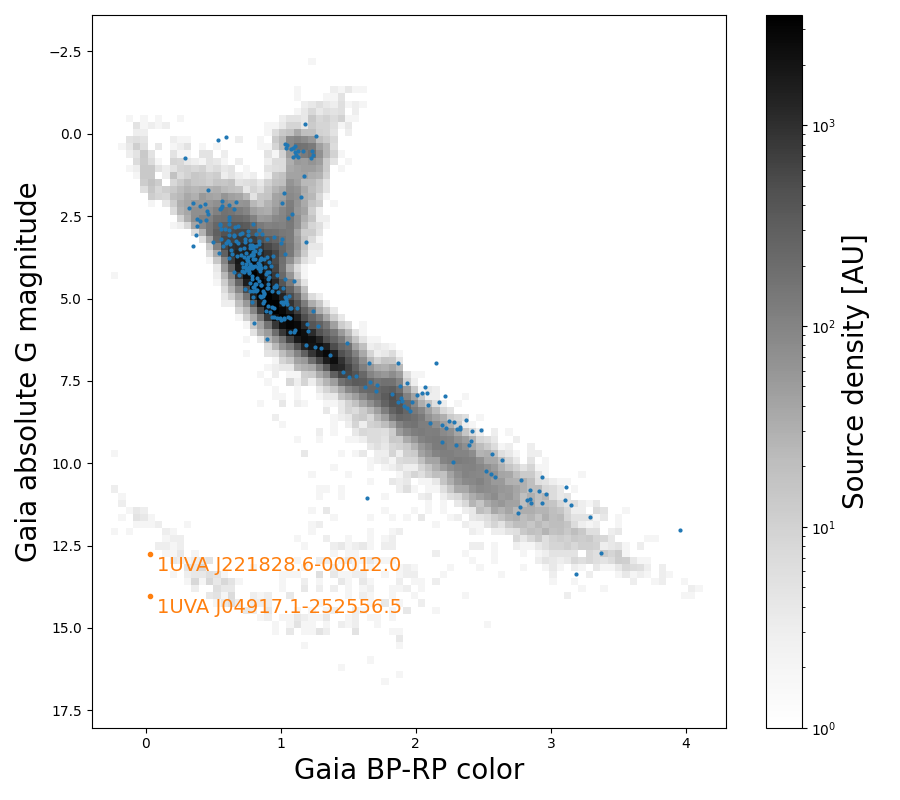

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,gaiaedr3_wd_match_id,simbad_match_id,gaiadr3_match_id,gfcat_src_id,gfcat_dist,flux_ne,src_name,otype,ogrp_simbad,match_distance_simbad,PQSO,PGal,PSS,match_distance_gaiadr3,Gmag_abs,BP-RP,ogrp_gaiadr3,Plx_dist,E_BP-RP,AG,RFRP,RFBP,RPlx,ls_peak_pval,ls_model_rchiq,BP-RP_corr,Gmag_abs_corr
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,arcsec,,,,,arcsec,,,,arcsec,,,,pc,,,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,int32,int32,int32,int64,float32,float32[2],bytes24,bytes32,bytes8,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
-1,11 .. 1,12.321346896575122,-25.432354111852234,0.15710679,-0.09986815,0.19939545,0.5981422,0.6211446,1174666,0.2521424,1 .. 2,True,73.65471 .. 41.309494,0.49720997 .. 1.8218318,0.0018140583 .. -100.0,13.624461 .. -100.0,1.0632669e-08 .. -1.0,5.7522326 .. -1.0,0.9973585 .. -100.0,-0.30658138 .. -10000.0,-1,357455,2,0.5271166,0.02530804,9,1842,2094,-1,-1.0,0.04259176 .. --,1UVA J04917.1-252556.5,WD*,Star,0.41890272,0.0,0.0,5e-05,0.9979328,14.043812,0.034575,WD*,99.60556,nan,nan,21.83,31.925,39.4121,-1.0,-1.0,0.034575,14.043812
-1,7 .. 2,334.6190008630954,-0.00334150877900888,0.18584667,-0.18340522,0.12893102,0.8110655,0.40349314,-1,-1.0,1 .. 2,True,121.26045 .. 42.269413,0.7279036 .. 0.8880146,0.0016065002 .. 0.005644754,27.450548 .. 11.66761,2.6516346e-07 .. 0.00661471,6.865675 .. 7.3747196,-100.0 .. -100.0,-10000.0 .. -10000.0,-1,94932,2,0.35823846,0.011588516,5,761,809,-1,-1.0,0.04008117 .. 0.07513158,1UVA J221828.6-00012.0,WD*,Star,0.3802346,0.0,0.0,5e-05,0.78486586,12.755576,0.029638,WD*,121.74485,nan,nan,33.492,80.685,48.3832,-1.0,-1.0,0.029638,12.755576


In [11]:
#Prepare HR figure
fig, axs = plt.subplots(1, 1, figsize=(9, 8),num="HR", clear=True)
fig.set_tight_layout(True)
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.01, hspace=0.01)
axs = np.array(axs).flatten()

dist_hr = 150
s2n_hr = 10
ag_max= 1
ebmr_max = 0.2
# -----  Plot GAIA-HR   ------

# Add absoption where gspphot present
sel_abs = ~tt_res["ag_gspphot"].mask * ~tt_res["ebpminrp_gspphot"].mask 
tt_res["bp_rp_corr"]= tt_res["bp_rp"]
tt_res["gmag_abs_corr"] = tt_res["gmag_abs"]
tt_res["bp_rp_corr"][sel_abs] = tt_res["bp_rp"][sel_abs] - tt_res["ebpminrp_gspphot"][sel_abs]
tt_res["gmag_abs_corr"][sel_abs] = tt_res["gmag_abs"][sel_abs] - tt_res["ag_gspphot"][sel_abs]
#display(tt_res[sel_abs])

#Select stars to show
#sel_qual = (tt_res["visibility_periods_used"]>8)+(tt_res["astrometric_excess_noise"]<1)
sel_dist = tt_res["dist"] < dist_hr 
sel_s2n = (tt_res["phot_bp_mean_flux_over_error"]>s2n_hr )*(tt_res["phot_rp_mean_flux_over_error"]>s2n_hr )*(tt_res["parallax_over_error"]>s2n_hr )
sel_ag = (tt_res["ag_gspphot"] <ag_max)*(tt_res["ag_gspphot"] >1e-8)
sel_eb =  (tt_res["ebpminrp_gspphot"]<ebmr_max)*(tt_res["ebpminrp_gspphot"] >1e-8)
sel_hr = sel_s2n  * ((sel_ag *sel_eb) + sel_dist)
print("Total/Selected Nr of sources",len(tt_res),sel_hr.sum())

# Plot
h = axs[0].hist2d(tt_res["bp_rp_corr"][sel_hr], tt_res["gmag_abs_corr"][sel_hr], bins=100, cmap="Greys",norm="log") #

# -----   Plot GAIA-VASCA-HR   ------
#"E_BP-RP","AG","RFRP", "RFBP", "RPlx"
tt_HR = rc.tt_sources[rc.tt_sources["Gmag_abs"]>-10] #Gmag_abs is only set for Rplx>4 in "post_process" script

# Add absoption where gspphot present
sel_vhr_abs = (tt_HR["AG"]>0) * (tt_HR["E_BP-RP"]>0) 
tt_HR["BP-RP_corr"]= tt_HR["BP-RP"]
tt_HR["Gmag_abs_corr"] = tt_HR["Gmag_abs"]
tt_HR["BP-RP_corr"][sel_vhr_abs] = tt_HR["BP-RP"][sel_vhr_abs] - tt_HR["E_BP-RP"][sel_vhr_abs]
tt_HR["Gmag_abs_corr"][sel_vhr_abs] = tt_HR["Gmag_abs"][sel_vhr_abs] - tt_HR["AG"][sel_vhr_abs]

#Select sources to show
sel_vhr_dist = tt_HR["Plx_dist"] < dist_hr 
sel_vhr_s2n = (tt_HR["RFRP"]>s2n_hr )*(tt_HR["RFBP"]>s2n_hr )*(tt_HR["RPlx"]>s2n_hr )
sel_vhr_ag = (tt_HR["AG"] <ag_max)*(tt_HR["AG"] >1e-8)
sel_vhr_eb =  (tt_HR["E_BP-RP"]<ebmr_max)*(tt_HR["E_BP-RP"] >1e-8)
sel_vhr = sel_vhr_s2n  * ((sel_vhr_ag *sel_vhr_eb) + sel_vhr_dist)
print("Total/Selected Nr of sources",len(tt_HR),sel_vhr.sum())


axs[0].plot(tt_HR["BP-RP_corr"][sel_vhr],tt_HR["Gmag_abs_corr"][sel_vhr],"o",markersize=2, label="1UVA")
#axs[0].invert_yaxis()
#axs[0].plot(tt_HR["BP-RP"][tt_HR["ogrp_gaiadr3"]=="WD*"],tt_HR["Gmag_abs"][tt_HR["ogrp_gaiadr3"]=="WD*"],"o",markersize=2)
axs[0].invert_yaxis()
axs[0].set_xlabel("Gaia BP-RP color", fontsize=20)
axs[0].set_ylabel("Gaia absolute G magnitude", fontsize=20)
axs[0].set_xlim([-0.4, 4.3])

# Add secondary axis
#secax = ax.secondary_xaxis("top", functions=(AA2K_np, K2AA_np))
#secay = axs[0].secondary_yaxis("right", functions=( mag2flux_np, flux2mag_np))
#secay.set_ylabel("Flux [$\mu$Jy]", fontsize=14)

fig.colorbar(h[3], ax=axs[0]).set_label(label="Source density [AU]",size=20)
#plt.legend()
#

# Add individual sources
add_srcs_ids = [357455,94932 ] #
tt_HR.add_index("rg_src_id")
idx_srcs = tt_HR.loc_indices["rg_src_id", add_srcs_ids]
axs[0].plot(tt_HR["BP-RP_corr"][idx_srcs],tt_HR["Gmag_abs_corr"][idx_srcs],"o",markersize=3, label="WDs", color = 'tab:orange')

for idx in idx_srcs:
    axs[0].annotate(str(tt_HR["src_name"][idx]),(tt_HR["BP-RP_corr"][idx]+0.05,tt_HR["Gmag_abs_corr"][idx]+0.05), fontsize=14, color = 'tab:orange',  horizontalalignment="left",verticalalignment="top")
plt.show()
fig.savefig(region_dir_name +"HR_1UVA.pdf")
display(tt_HR[idx_srcs])

In [12]:
from astroquery.simbad import Simbad

testSimbad = Simbad()

#testSimbad.list_votable_fields()
all_vo_fields = ["biblio","cel","cl.g","coo(opt)","coo_bibcode","coo_err_angle","coo_err_maja","coo_err_mina","coo_qual","coo_wavelength","coordinates","dec(opt)","dec_prec","diameter","dim","dim_angle","dim_bibcode","dim_incl","dim_majaxis","dim_minaxis","dim_qual","dim_wavelength","dimensions","distance","distance_result","einstein","fe_h","flux(filtername)","flux_bibcode(filtername)","flux_error(filtername)","flux_name(filtername)","flux_qual(filtername)","flux_system(filtername)","flux_unit(filtername)","fluxdata(filtername)","gcrv","gen","gj","hbet","hbet1","hgam","id(opt)","ids","iras","irc","iso","iue","jp11","link_bibcode","main_id","measurements","membership","mesplx","mespm","mk","morphtype","mt","mt_bibcode","mt_qual","otype","otype(opt)","otypes","parallax","plx","plx_bibcode","plx_error","plx_prec","plx_qual","pm","pm_bibcode","pm_err_angle","pm_err_maja","pm_err_mina","pm_qual","pmdec","pmdec_prec","pmra","pmra_prec","pos","posa","propermotions","ra(opt)","ra_prec","rot","rv_value","rvz_bibcode","rvz_error","rvz_qual","rvz_radvel","rvz_type","rvz_wavelength","sao","sp","sp_bibcode","sp_nature","sp_qual","sptype","td1","typed_id","ubv","uvby","uvby1","v*","velocity","xmm","z_value"]

#for vo_field in all_vo_fields:
#    print("*",vo_field)
#    testSimbad.get_field_description(vo_field)

### Distance distribution of GAIA associated sources

_q,ra,dec,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RUWE,FG,e_FG,Gmag,FBP,e_FBP,BPmag,FRP,e_FRP,RPmag,BP-RP,RV,e_RV,Vbroad,GRVSmag,QSO,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,__Fe_H_,Dist,A0,HIP,PS1,SDSS13,SKYM2,TYC2,URAT1,AllWISE,APASS9,GSC23,RAVE5,_2MASS,RAVE6,RAJ2000,DEJ2000,PQSO,PGal,PSS,RPlx,VarFlag,o_Gmag,RFRP,RFBP,AG,E_BP-RP,rg_src_id,match_distance,gaiadr3_match_id,Gmag_abs,Plx_dist,ogrp
,deg,deg,,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,,,mag,,,mag,mag,km / s,km / s,km / s,mag,,,,,,,,,,,,K,log(cm.s**-2),,pc,mag,,,,,,,,,,,,,deg,deg,,,,,,,,,mag,mag,,arcsec,,,pc,
int32,float64,float64,int64,float64,float64,float64,float32,float64,float64,float32,float64,float32,float64,float64,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float32,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,int32,int64,int64,int32,bytes12,bytes15,bytes19,int32,bytes10,bytes16,bytes17,bytes21,float64,float64,float64,float64,float64,float64,bytes13,int16,float32,float32,float32,float32,int32,float64,int32,float32,float64,bytes8
1,150.2,2.1,3836069006998531584,2.2872,3.3137,--,--,--,--,--,--,--,--,95.82888,1.689,20.733625,93.75,16.38,20.408556,130.9,9.985,19.455320,0.953236,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,110481501947501974,1237651753997304055,--,--,--,J100046.74+020404.4,--,N6SS000981,--,--,--,150.2,2.1,0.001869,0.000724,0.996765,--,NOT_AVAILABLE,79,13.11,5.725,--,--,41,0.6956587221689177,0,-100.0,--,none
2,150.1,2.0,3836046123412862208,1.5776,2.0453,--,--,--,--,--,--,--,--,90.12499,2.676,20.800253,37.12,20.52,21.414429,59.56,10.83,20.310590,1.103838,--,--,--,--,0,0,0,0,0,0,0,0,0,0,0,--,--,--,--,--,--,110451501456232172,1237651736280760581,--,--,--,J100034.94+020234.9,--,N6SS004829,--,--,--,150.1,2.0,0.001265,0.000013,0.997987,--,NOT_AVAILABLE,43,5.497,1.809,--,--,68,0.6420858569707824,1,-100.0,--,none
4,150.1,2.1,3836257710681556224,0.5228,0.5439,-0.0737,0.5331,0.702,-0.580,0.607,0.396,0.641,1.065,231.69009,2.456,19.775099,160.4,10.57,19.825287,132.1,14.81,19.445590,0.379698,--,--,--,--,1,0,0,0,0,0,1,0,0,0,0,--,--,--,--,--,--,110521501020297033,1237651753997238486,--,--,--,J100024.44+020619.5,--,N6SV003245,--,--,--,150.1,2.1,1.000000,0.000000,0.000000,-0.1383,VARIABLE,182,8.917,15.18,--,--,87,1.015315761207988,2,-100.0,--,AGN
7,215.1,52.6,1607957522794289024,0.1805,0.2101,-0.4327,0.2279,0.356,0.190,0.223,0.302,0.256,1.036,311.79894,1.36,19.452680,178.4,9.809,19.709816,189.3,7.18,19.055190,0.654627,--,--,--,--,1,0,0,0,0,0,1,0,0,0,0,--,--,--,--,--,--,171142150651746989,1237661385994862739,--,--,--,J142015.62+523718.5,--,N5MV001218,--,--,--,215.1,52.6,1.000000,0.000000,0.000000,-1.8990,VARIABLE,482,26.36,18.19,--,--,302,0.26795579682948123,3,-100.0,--,AGN
8,215.0,52.7,1607958480571152256,0.8988,0.7715,-1.1739,0.6843,0.532,-0.092,1.013,0.524,0.894,1.079,127.05163,2.726,20.427416,98.51,10.98,20.354832,127.2,7.357,19.486479,0.868353,--,--,--,--,1,0,0,0,0,0,1,0,0,0,0,--,--,--,--,--,--,171212150426430532,1237661385994862858,--,--,--,J142010.22+524029.6,--,N5MV001750,--,--,--,215.0,52.7,0.999765,0.000220,0.000015,-1.7155,VARIABLE,283,17.29,8.972,--,--,314,0.5654019830257911,4,-100.0,--,AGN
9,214.9,52.5,1607951746062355328,0.2074,0.2337,0.1023,0.2656,0.429,-0.239,0.256,-0.357,0.272,0.966,233.47251,0.8803,19.766777,140.9,7.083,19.965982,148.7,6.695,19.317305,0.648678,--,--,--,--,1,0,0,0,0,0,1,0,0,0,0,--,--,--,--,--,--,171052149430476033,1237661385994862854,--,--,--,J141946.35+523246.3,--,N5MV000642,--,--,--,214.9,52.5,1.000000,0.000000,0.000000,0.3850,VARIABLE,523,22.21,19.9,--,--,336,0.5780435001189599,5,-100.0,9775.1711,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

/tmp/ipykernel_22984/654275962.py:3: RuntimeWarning: invalid value encountered in log10
  ax.hist(np.log10(rc.tt_sources["Plx_dist"]),bins=100)


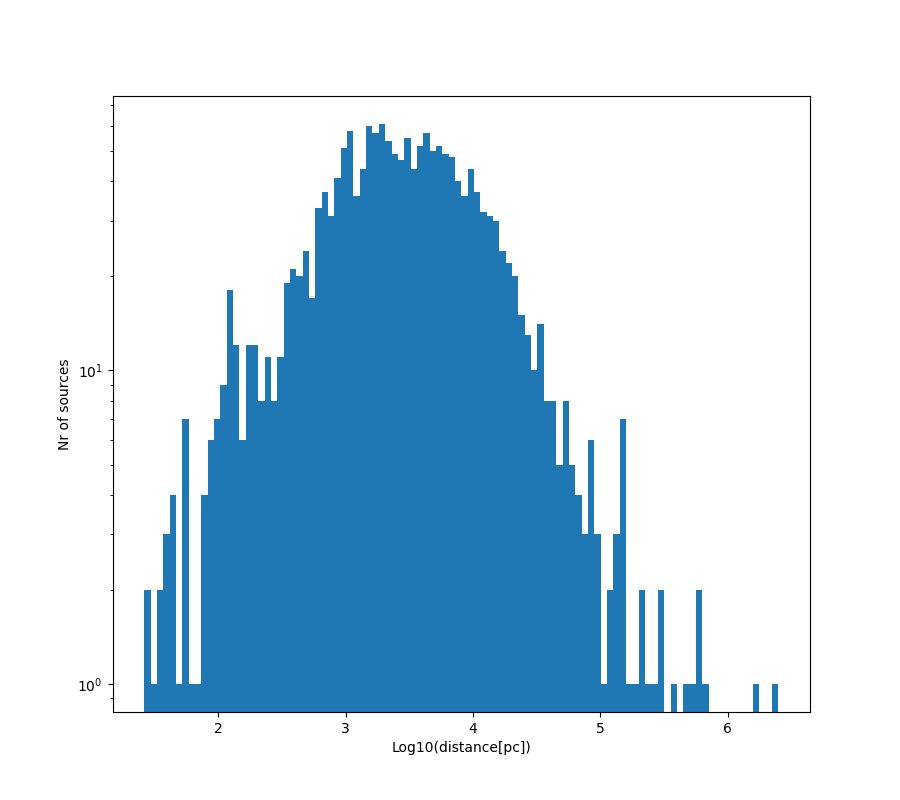

In [13]:
display(rc.tt_gaiadr3)
fig, ax = plt.subplots(1, 1, figsize=(9, 8),num="Dist", clear=True)
ax.hist(np.log10(rc.tt_sources["Plx_dist"]),bins=100)
plt.yscale('log')
plt.xlabel("Log10(distance[pc])")
plt.ylabel("Nr of sources")
plt.show()

In [14]:
1/0.819

1.221001221001221